In [ ]:
import copy
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2>Load Data</h2>

In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/softcom/main22.csv')

In [ ]:
weather_data

,date,station,max_temp,min_temp,rainfall,cloud,humidity,wind_speed,sunshine
0,1953-01-01,Dhaka,25.18,10.92,10,1.65,70.48,1.433178,6.427503
1,1953-02-01,Dhaka,29.52,14.74,2,2.07,64.50,1.433178,6.427503
2,1953-03-01,Dhaka,32.65,21.70,90,3.74,73.48,1.433178,6.427503
3,1953-04-01,Dhaka,35.02,23.44,90,3.37,68.83,1.433178,6.427503
4,1953-05-01,Dhaka,32.77,24.19,274,5.84,80.74,1.433178,6.427503
...,...,...,...,...,...,...,...,...,...
6643,2022-08-01,Barisal,32.91,26.26,331,5.77,84.84,2.710000,5.620000
6644,2022-09-01,Barisal,32.85,25.91,278,5.20,87.03,1.080000,4.500000
6645,2022-10-01,Barisal,32.41,23.66,476,2.84,85.32,0.990000,7.320000
6646,2022-11-01,Barisal,30.91,18.14,0,1.17,81.03,0.330000,8.730000


In [ ]:
weather_data = weather_data[['date', 'station', 'max_temp', 'min_temp', 'rainfall', 'cloud', 'humidity', 'wind_speed', 'sunshine']]
dhaka = weather_data[weather_data['station'] == 'Dhaka']
raj = weather_data[weather_data['station'] == 'Rajshahi']
khulna = weather_data[weather_data['station'] == 'Khulna']
mymen = weather_data[weather_data['station'] == 'Mymensingh']
chitt = weather_data[weather_data['station'] == 'Chittagong']
syl = weather_data[weather_data['station'] == 'Sylhet']
rang = weather_data[weather_data['station'] == 'Rangpur']
bar = weather_data[weather_data['station'] == 'Barisal']

In [ ]:
dhaka.tail(5)

,date,station,max_temp,min_temp,rainfall,cloud,humidity,wind_speed,sunshine
835,2022-08-01,Dhaka,34.21,27.36,130,5.45,75.03,3.10,5.40
836,2022-09-01,Dhaka,33.21,26.68,282,5.80,80.97,2.24,3.64
837,2022-10-01,Dhaka,32.72,24.91,297,3.71,73.97,2.22,5.51
838,2022-11-01,Dhaka,31.04,20.77,0,1.70,63.77,2.05,5.99
839,2022-12-01,Dhaka,27.41,17.24,4,0.52,69.23,1.89,4.45


In [ ]:
dhaka.shape

(840, 9)

In [ ]:
raj.shape

(708, 9)

In [ ]:

TRAIN_TEST_SPLIT_DATE = '2005-01-01'
TRAIN_VALIDATION_SPLIT_DATE = '1985-01-01'

<h1>EDA Plot</h1>

Dhaka


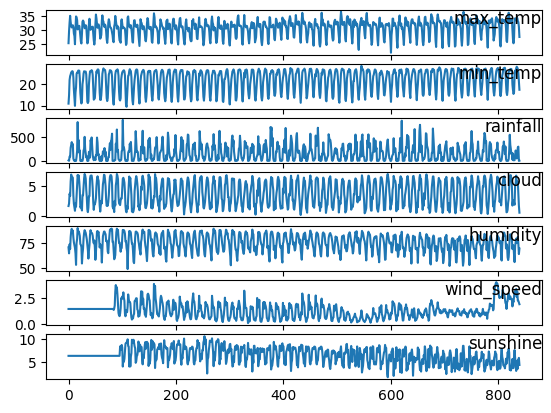

Rajshahi


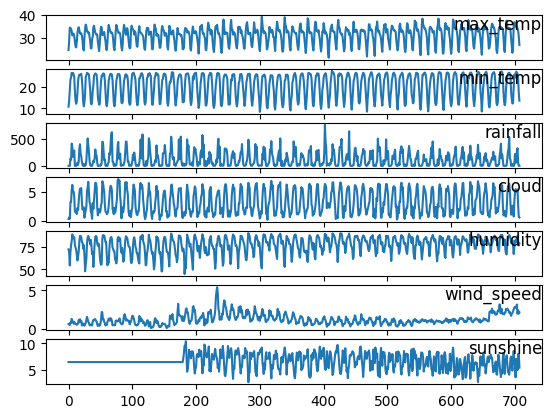

Khulna


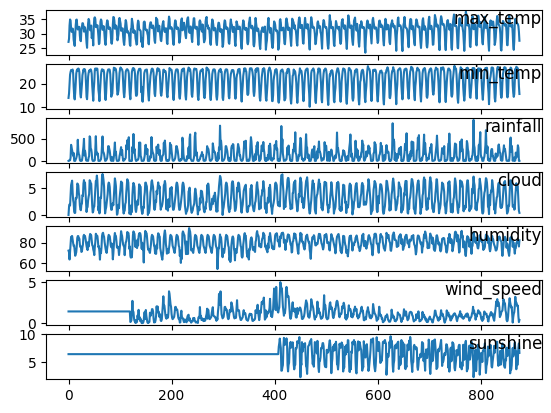

Mymensingh


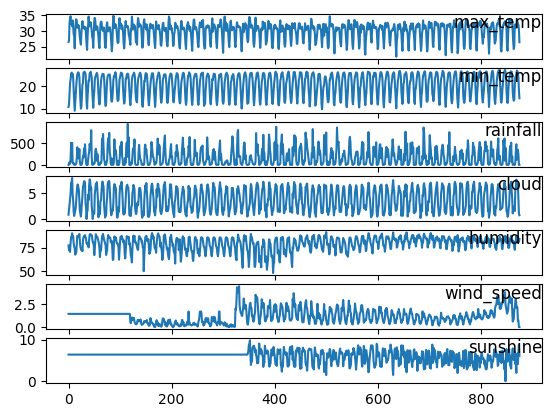

Rangpur


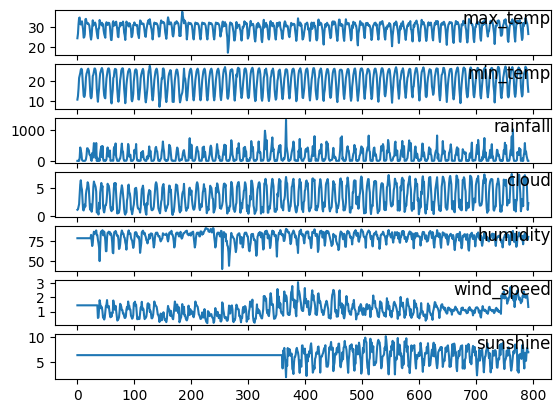

Sylhet


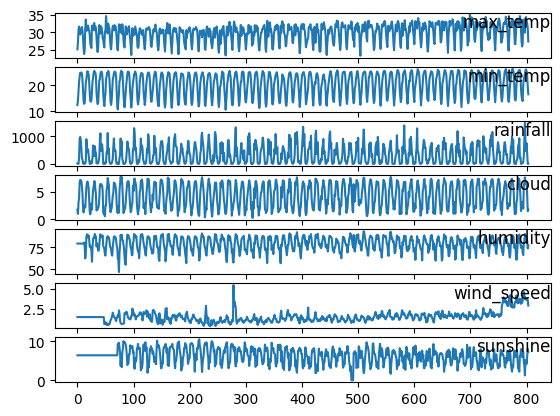

Chittagong


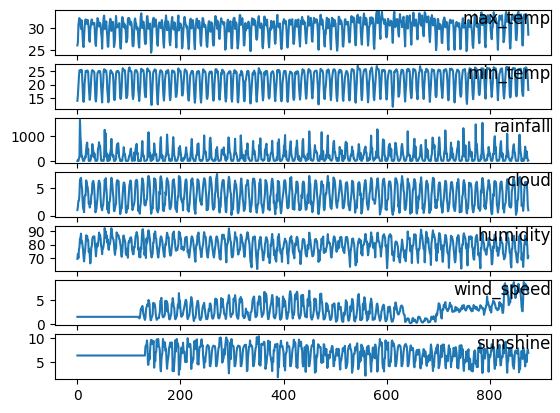

Barisal


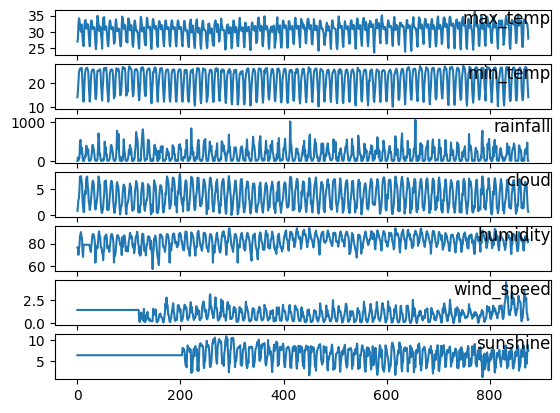

In [ ]:
# time series plot of each feature over time
for city in [dhaka,raj,khulna,mymen,rang,syl,chitt,bar]:
    print(city['station'].iloc[0])
    values = city.values

    groups = [2, 3, 4, 5, 6, 7, 8]
    i = 1

    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(city.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()

<h2>Scaling the Data and Supervised Data</h2>

In [ ]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data).astype(float)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
dhaka = dhaka.set_index('date').drop(columns=['station'])
raj = raj.set_index('date').drop(columns=['station'])
khulna = khulna.set_index('date').drop(columns=['station'])
mymen = mymen.set_index('date').drop(columns=['station'])
chitt = chitt.set_index('date').drop(columns=['station'])
syl = syl.set_index('date').drop(columns=['station'])
rang = rang.set_index('date').drop(columns=['station'])
bar = bar.set_index('date').drop(columns=['station'])

In [ ]:
#1 mnth 1 feat
# transform daily weather data into supervised data, with 1 month's data used to make predictions
def make_supervised(data):
    data_sup = series_to_supervised(data, n_in=7, n_out=1)  # Set n_out to 1
    drop_cols = ['var2(t)', 'var3(t)', 'var4(t)','var5(t)','var6(t)', 'var7(t)']

    for t in range(1, 1):
        for feat in range(1, 7):
            if not (feat == 1):
               drop_cols.append(f'var{feat}(t+{t})')
    data_sup = data_sup.drop(columns=drop_cols)

   # if len(data_sup) != len(data) - 13:
    #    print(f"Length mismatch: Expected {len(data) - 13} rows, received {len(data_sup)}")

    return data_sup

In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(dhaka) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(dhaka) * 0.10)
test_size = len(dhaka) - train_size - validation_size

dhaka_train, dhaka_validation, dhaka_test = \
    dhaka[0:train_size], dhaka[train_size:train_size+validation_size], dhaka[train_size+validation_size:]



In [ ]:
dhaka_train_sup = make_supervised(dhaka_train)
dhaka_validation_sup = make_supervised(dhaka_validation)
dhaka_test_sup = make_supervised(dhaka_test)

In [ ]:
dhaka_train_sup

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var1(t-6),var2(t-6),var3(t-6),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
date,,,,,,,,,,,,,,,,,,,,,
1953-08-01,25.18,10.92,10.0,1.65,70.48,1.433178,6.427503,29.52,14.74,2.0,...,1.433178,6.427503,30.83,25.42,392.0,6.65,88.90,1.433178,6.427503,31.39
1953-09-01,29.52,14.74,2.0,2.07,64.50,1.433178,6.427503,32.65,21.70,90.0,...,1.433178,6.427503,31.39,25.72,326.0,6.58,85.55,1.433178,6.427503,31.63
1953-10-01,32.65,21.70,90.0,3.74,73.48,1.433178,6.427503,35.02,23.44,90.0,...,1.433178,6.427503,31.63,25.49,352.0,6.47,87.20,1.433178,6.427503,30.98
1953-11-01,35.02,23.44,90.0,3.37,68.83,1.433178,6.427503,32.77,24.19,274.0,...,1.433178,6.427503,30.98,22.88,52.0,3.45,80.35,1.433178,6.427503,28.64
1953-12-01,32.77,24.19,274.0,5.84,80.74,1.433178,6.427503,31.36,25.13,333.0,...,1.433178,6.427503,28.64,17.18,13.0,2.03,75.40,1.433178,6.427503,27.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-08-01,24.46,14.48,23.0,2.10,70.22,0.870000,4.680000,26.07,15.20,56.0,...,1.490000,4.170000,31.77,26.35,563.0,7.03,83.61,1.320000,3.100000,32.12
2008-09-01,26.07,15.20,56.0,1.69,62.16,0.830000,6.570000,31.65,21.96,45.0,...,1.320000,3.100000,32.12,26.49,319.0,6.39,82.22,0.830000,4.040000,32.57
2008-10-01,31.65,21.96,45.0,3.87,67.70,1.110000,5.920000,34.48,24.51,91.0,...,0.830000,4.040000,32.57,26.24,279.0,5.87,81.42,0.720000,4.410000,31.40


In [ ]:
def x_y_split(data):
    y_cols = ['var1(t)']
    x_data = data.drop(columns=y_cols)
    y_data = data[y_cols].values
    return x_data, y_data

In [ ]:
x_train_dhaka, y_train_dhaka = x_y_split(dhaka_train_sup)
x_validation_dhaka, y_validation_dhaka = x_y_split(dhaka_validation_sup)
x_test_dhaka, y_test_dhaka = x_y_split(dhaka_test_sup)

In [ ]:
# reshape into (num_days, num_timesteps, num_features)
def reshape_data(x_train, x_validation, x_test):
    x_train = x_train.values.reshape((x_train.shape[0], 7, 7))
    x_validation = x_validation.values.reshape((x_validation.shape[0], 7, 7))
    x_test = x_test.values.reshape((x_test.shape[0], 7, 7))
    return x_train, x_validation, x_test

In [ ]:
x_train_dhaka, x_validation_dhaka, x_test_dhaka = reshape_data(x_train_dhaka, x_validation_dhaka, x_test_dhaka)

In [ ]:
from keras.layers import GRU, Dropout
from keras.callbacks import EarlyStopping

def fit_gru(model_name, x_train, y_train, x_validation, y_validation):
    model = Sequential()

    model.add(GRU(32, activation='relu', input_shape=(7, 7), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(32))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Adjust output units to 1 for single-feature prediction
    model.compile(loss='mae', optimizer='adam')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=100, batch_size=32,
                        validation_data=(x_validation, y_validation),
                        callbacks=[early_stopping],
                        verbose=0, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f"{model_name} Model Performance")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model


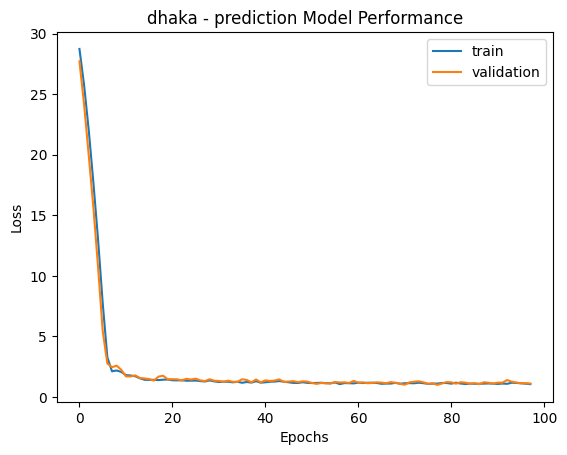

In [ ]:
dhaka_model = fit_gru('dhaka - prediction', x_train_dhaka, y_train_dhaka,
                      x_validation_dhaka, y_validation_dhaka)


In [ ]:
# Make predictions
y_pred_train_dhaka = dhaka_model.predict(x_train_dhaka)
y_pred_validation_dhaka = dhaka_model.predict(x_validation_dhaka)
y_pred_test_dhaka = dhaka_model.predict(x_test_dhaka)

3/3 [==============================] - 0s 6ms/step


In [ ]:
y_pred_train_dhaka

array([[32.02548 ],
       [31.917423],
       [30.211037],
       [30.447685],
       [26.073063],
       [24.83295 ],
       [27.80739 ],
       [33.156033],
       [33.15603 ],
       [32.040493],
       [32.014126],
       [32.00836 ],
       [32.024788],
       [32.008915],
       [31.915966],
       [27.789608],
       [26.067415],
       [26.069237],
       [27.923168],
       [33.156025],
       [33.154343],
       [33.1556  ],
       [32.012474],
       [32.030914],
       [32.03595 ],
       [32.01981 ],
       [31.929867],
       [29.363346],
       [26.056505],
       [25.215206],
       [27.87722 ],
       [32.2547  ],
       [33.142563],
       [32.045036],
       [32.10786 ],
       [32.032013],
       [32.00889 ],
       [31.856642],
       [30.944439],
       [28.334232],
       [26.386547],
       [25.76446 ],
       [26.022322],
       [32.471256],
       [33.155495],
       [32.823654],
       [32.03948 ],
       [32.031494],
       [32.02962 ],
       [32.02793 ],


In [ ]:
y_pred_test_dhaka

array([[31.977829],
       [31.337423],
       [31.082394],
       [28.87124 ],
       [26.067268],
       [24.816628],
       [26.102453],
       [33.151722],
       [33.14284 ],
       [32.03824 ],
       [32.027134],
       [32.031666],
       [32.017048],
       [31.88071 ],
       [30.17313 ],
       [30.172392],
       [28.712631],
       [25.96883 ],
       [27.897247],
       [33.156033],
       [33.156   ],
       [33.156006],
       [32.01194 ],
       [32.030613],
       [32.018703],
       [31.481888],
       [31.821667],
       [26.066105],
       [25.751614],
       [24.811798],
       [27.91184 ],
       [33.139603],
       [32.042885],
       [32.02999 ],
       [31.65777 ],
       [31.945593],
       [31.91454 ],
       [30.901863],
       [30.671633],
       [30.172485],
       [28.345785],
       [25.752962],
       [25.063173],
       [27.974453],
       [33.14788 ],
       [33.15561 ],
       [32.029217],
       [32.029472],
       [32.01989 ],
       [31.872429],


In [ ]:
dhaka_test

,max_temp,min_temp,rainfall,cloud,humidity,wind_speed,sunshine
date,,,,,,,
2016-01-01,24.87,14.15,3,0.97,68.87,1.19,5.05
2016-02-01,29.80,19.08,13,2.14,63.45,1.08,6.17
2016-03-01,33.11,22.56,55,2.74,59.58,1.28,7.14
2016-04-01,35.14,26.91,55,4.20,72.40,1.45,7.37
2016-05-01,33.68,24.90,212,5.13,74.48,1.43,5.76
...,...,...,...,...,...,...,...
2022-08-01,34.21,27.36,130,5.45,75.03,3.10,5.40
2022-09-01,33.21,26.68,282,5.80,80.97,2.24,3.64
2022-10-01,32.72,24.91,297,3.71,73.97,2.22,5.51


In [ ]:
y_test_dhaka.shape

(77, 1)

In [ ]:
y_pred_test_dhaka.shape

(77, 1)

In [ ]:
# Evaluate the model (you may need to modify this based on your specific evaluation criteria)
train_mae = mean_absolute_error(y_train_dhaka, y_pred_train_dhaka)
validation_mae = mean_absolute_error(y_validation_dhaka, y_pred_validation_dhaka)
test_mae = mean_absolute_error(y_test_dhaka, y_pred_test_dhaka)

In [ ]:
print(f"Train MAE: {train_mae:.2f}")
print(f"Validation MAE: {validation_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Train MAE: 1.03
Validation MAE: 1.00
Test MAE: 1.79


In [ ]:
dates = dhaka_test.index[7:]

# Assuming y_test_dhaka and y_pred_test_dhaka should start from index 7 as well
y_test_dhaka = y_test_dhaka[7:]
y_pred_test_dhaka = y_pred_test_dhaka[7:]

In [ ]:
print("Length of dates:", len(dates))
print("Length of y_test_dhaka:", len(y_test_dhaka))
print("Length of y_pred_test_dhaka:", len(y_pred_test_dhaka))

Length of dates: 77
Length of y_test_dhaka: 70
Length of y_pred_test_dhaka: 70


In [ ]:
dhaka_test.shape

(84, 7)

In [ ]:
y_test_dhaka

array([[30.48],
       [32.79],
       [34.5 ],
       [33.04],
       [31.98],
       [32.59],
       [33.08],
       [31.99],
       [30.19],
       [26.76],
       [23.6 ],
       [29.22],
       [33.32],
       [33.03],
       [32.33],
       [33.54],
       [32.79],
       [33.8 ],
       [34.13],
       [31.99],
       [30.29],
       [26.14],
       [27.17],
       [28.35],
       [31.51],
       [33.68],
       [34.59],
       [33.58],
       [32.97],
       [33.75],
       [33.34],
       [32.06],
       [30.32],
       [24.76],
       [24.02],
       [27.45],
       [32.29],
       [33.83],
       [33.39],
       [33.38],
       [33.02],
       [32.94],
       [33.54],
       [33.16],
       [30.77],
       [25.97],
       [25.58],
       [29.53],
       [34.47],
       [36.13],
       [34.97],
       [32.5 ],
       [32.84],
       [33.23],
       [33.89],
       [33.53],
       [30.  ],
       [26.51],
       [25.15],
       [27.15],
       [33.92],
       [34.1 ],
       [

Actual and Predicted Max Temperature Values:
    Date  Actual Max Temp  Predicted Max Temp
0  Day 1            30.48           33.151722
1  Day 2            32.79           33.142841
2  Day 3            34.50           32.038239
3  Day 4            33.04           32.027134
4  Day 5            31.98           32.031666
5  Day 6            32.59           32.017048
6  Day 7            33.08           31.880711


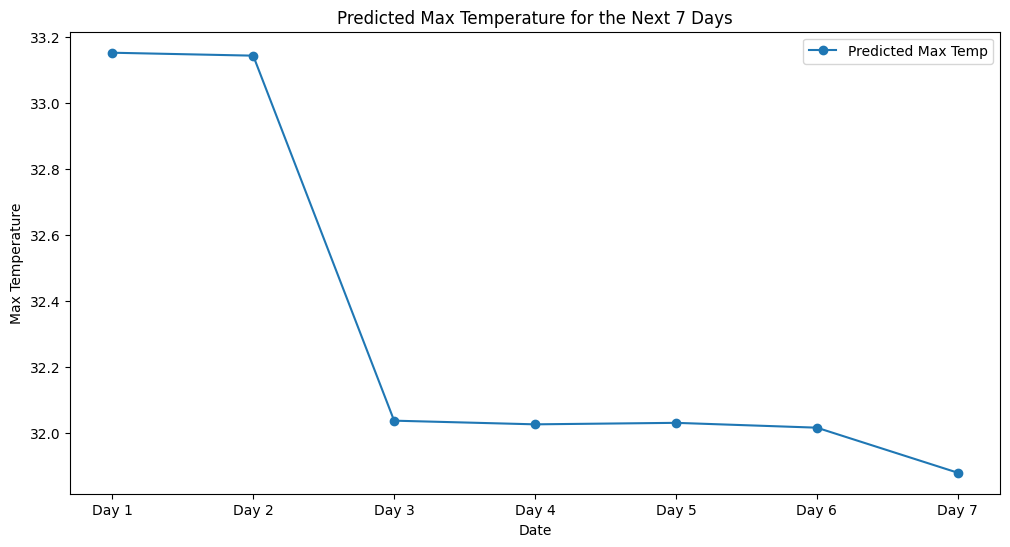

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = dhaka_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 7

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = f"Day {i - len(dates) + 1}"  # You can modify this based on your requirement
    actual_temp = y_test_dhaka[i - len(dates)][0]  # You won't have actual values for the future
    predicted_temp = y_pred_test_dhaka[i - len(dates)][0]  # Use double indexing to access the value

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_temp,
        'Predicted Max Temp': predicted_temp
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table
print("Actual and Predicted Max Temperature Values:")
print(results_df)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted Max Temp', marker='o')
plt.title("Predicted Max Temperature for the Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()
plt.show()


Actual and Predicted Max Temperature Values:
    Date  Actual Max Temp  Predicted Max Temp
0  Day 1            30.48           33.151722
1  Day 2            32.79           33.142841
2  Day 3            34.50           32.038239
3  Day 4            33.04           32.027134
4  Day 5            31.98           32.031666
5  Day 6            32.59           32.017048
6  Day 7            33.08           31.880711


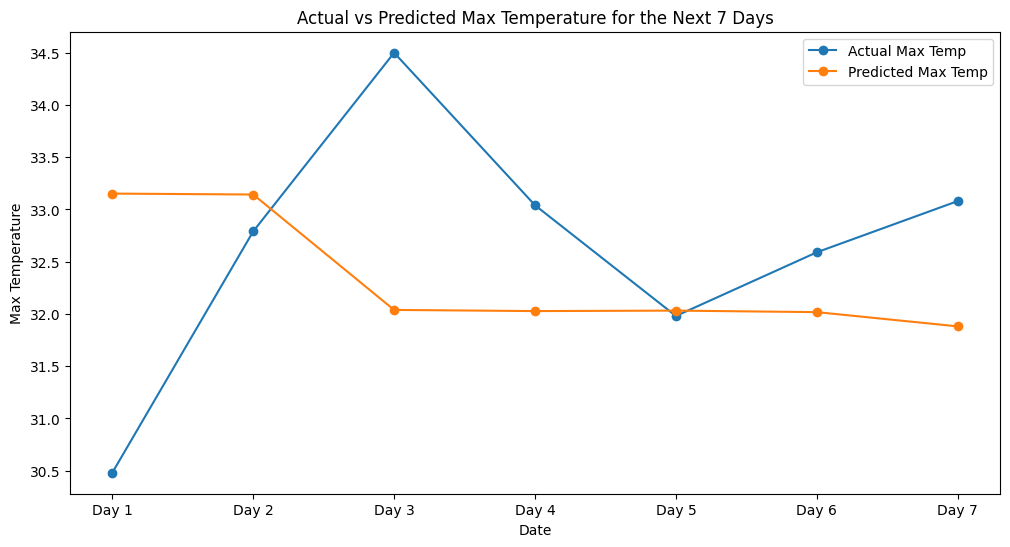

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = dhaka_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 7

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = f"Day {i - len(dates) + 1}"  # You can modify this based on your requirement
    actual_temp = y_test_dhaka[i - len(dates)][0]  # You won't have actual values for the future
    predicted_temp = y_pred_test_dhaka[i - len(dates)][0]  # Use double indexing to access the value

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_temp,
        'Predicted Max Temp': predicted_temp
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table
print("Actual and Predicted Max Temperature Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual Max Temp', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted Max Temp', marker='o')
plt.title("Actual vs Predicted Max Temperature for the Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()
plt.show()


Actual and Predicted Max Temperature Values:
         Date  Actual Max Temp  Predicted Max Temp
0  2016-01-01            30.48           33.151722
1  2016-02-01            32.79           33.142841
2  2016-03-01            34.50           32.038239
3  2016-04-01            33.04           32.027134
4  2016-05-01            31.98           32.031666
5  2016-06-01            32.59           32.017048
6  2016-07-01            33.08           31.880711


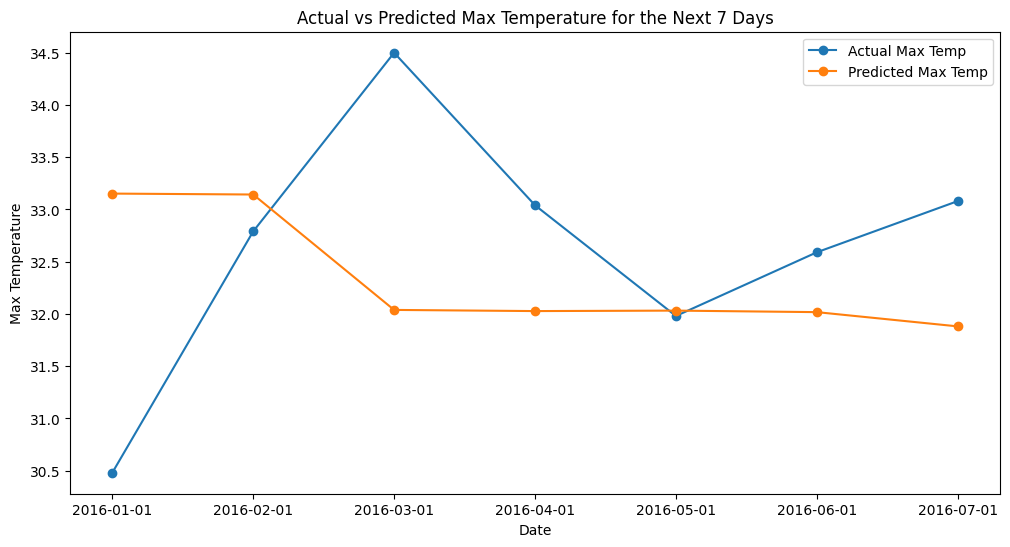

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = dhaka_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 7

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_temp = y_test_dhaka[i - len(dates)][0]  # You won't have actual values for the future
    predicted_temp = y_pred_test_dhaka[i - len(dates)][0]  # Use double indexing to access the value

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_temp,
        'Predicted Max Temp': predicted_temp
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Max Temperature Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual Max Temp', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted Max Temp', marker='o')
plt.title("Actual vs Predicted Max Temperature for the Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()
plt.show()


# **multiple target**


In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/softcom/main22.csv')

weather_data = weather_data[['date', 'station', 'max_temp', 'min_temp', 'rainfall', 'cloud', 'humidity', 'wind_speed', 'sunshine']]


dhaka = weather_data[weather_data['station'] == 'Dhaka']
raj = weather_data[weather_data['station'] == 'Rajshahi']
khulna = weather_data[weather_data['station'] == 'Khulna']
mymen = weather_data[weather_data['station'] == 'Mymensingh']
chitt = weather_data[weather_data['station'] == 'Chittagong']
syl = weather_data[weather_data['station'] == 'Sylhet']
rang = weather_data[weather_data['station'] == 'Rangpur']
bar = weather_data[weather_data['station'] == 'Barisal']
dhaka['date'] = pd.to_datetime(dhaka['date'])
raj['date'] = pd.to_datetime(raj['date'])
khulna['date'] = pd.to_datetime(khulna['date'])
mymen['date'] = pd.to_datetime(mymen['date'])
chitt['date'] = pd.to_datetime(chitt['date'])
syl['date'] = pd.to_datetime(syl['date'])
rang['date'] = pd.to_datetime(rang['date'])
bar['date'] = pd.to_datetime(bar['date'])


<ipython-input-38-8d6ca75158f4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dhaka['date'] = pd.to_datetime(dhaka['date'])
<ipython-input-38-8d6ca75158f4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raj['date'] = pd.to_datetime(raj['date'])
<ipython-input-38-8d6ca75158f4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data).astype(float)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
dhaka = dhaka.set_index('date').drop(columns=['station'])
mymen = mymen.set_index('date').drop(columns=['station'])
raj = raj.set_index('date').drop(columns=['station'])
khulna = khulna.set_index('date').drop(columns=['station'])
chitt = chitt.set_index('date').drop(columns=['station'])
rang = rang.set_index('date').drop(columns=['station'])
syl = syl.set_index('date').drop(columns=['station'])
bar = bar.set_index('date').drop(columns=['station'])

In [ ]:

def make_supervised(data):
    data_sup = series_to_supervised(data, n_in=7, n_out=1)
    drop_cols = ['var2(t)', 'var4(t)', 'var6(t)', 'var7(t)']

    for t in range(1, 1):
        for feat in range(1, 7):
            if not (feat == 1 or feat == 3 or feat == 5):
               drop_cols.append(f'var{feat}(t+{t})')
    data_sup = data_sup.drop(columns=drop_cols)

    # data_sup = data_sup.set_index(data.index[13:])
    return data_sup


In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(dhaka) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(dhaka) * 0.10)
test_size = len(dhaka) - train_size - validation_size

dhaka_train, dhaka_validation, dhaka_test = \
    dhaka[0:train_size], dhaka[train_size:train_size+validation_size], dhaka[train_size+validation_size:]



In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(mymen) * 0.7)  # Adjust the split ratio as needed
validation_size = int(len(mymen) * 0.15)
test_size = len(mymen) - train_size - validation_size

mymen_train, mymen_validation, mymen_test = \
    mymen[0:train_size], mymen[train_size:train_size+validation_size], mymen[train_size+validation_size:]


In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(raj) * 0.7)  # Adjust the split ratio as needed
validation_size = int(len(raj) * 0.15)
test_size = len(raj) - train_size - validation_size

raj_train, raj_validation, raj_test = \
    raj[0:train_size], raj[train_size:train_size+validation_size], raj[train_size+validation_size:]


In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(khulna) * 0.7)  # Adjust the split ratio as needed
validation_size = int(len(khulna) * 0.15)
test_size = len(khulna) - train_size - validation_size

khulna_train, khulna_validation, khulna_test = \
    khulna[0:train_size], khulna[train_size:train_size+validation_size], khulna[train_size+validation_size:]


In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(chitt) * 0.7)  # Adjust the split ratio as needed
validation_size = int(len(chitt) * 0.15)
test_size = len(chitt) - train_size - validation_size

chitt_train, chitt_validation, chitt_test = \
    chitt[0:train_size], chitt[train_size:train_size+validation_size], chitt[train_size+validation_size:]


In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(rang) * 0.7)  # Adjust the split ratio as needed
validation_size = int(len(rang) * 0.15)
test_size = len(rang) - train_size - validation_size

rang_train, rang_validation, rang_test = \
    rang[0:train_size], rang[train_size:train_size+validation_size], rang[train_size+validation_size:]


In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(syl) * 0.7)  # Adjust the split ratio as needed
validation_size = int(len(syl) * 0.15)
test_size = len(syl) - train_size - validation_size

syl_train, syl_validation, syl_test = \
    syl[0:train_size], syl[train_size:train_size+validation_size], syl[train_size+validation_size:]


In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(bar) * 0.7)  # Adjust the split ratio as needed
validation_size = int(len(bar) * 0.15)
test_size = len(bar) - train_size - validation_size

bar_train, bar_validation, bar_test = \
    bar[0:train_size], bar[train_size:train_size+validation_size], bar[train_size+validation_size:]


In [ ]:
dhaka_train_sup = make_supervised(dhaka_train)
dhaka_validation_sup = make_supervised(dhaka_validation)
dhaka_test_sup = make_supervised(dhaka_test)

In [ ]:
mymen_train_sup = make_supervised(mymen_train)
mymen_validation_sup = make_supervised(mymen_validation)
mymen_test_sup = make_supervised(mymen_test)


In [ ]:
raj_train_sup = make_supervised(raj_train)
raj_validation_sup = make_supervised(raj_validation)
raj_test_sup = make_supervised(raj_test)


In [ ]:
khulna_train_sup = make_supervised(khulna_train)
khulna_validation_sup = make_supervised(khulna_validation)
khulna_test_sup = make_supervised(khulna_test)


In [ ]:
chitt_train_sup = make_supervised(chitt_train)
chitt_validation_sup = make_supervised(chitt_validation)
chitt_test_sup = make_supervised(chitt_test)


In [ ]:
rang_train_sup = make_supervised(rang_train)
rang_validation_sup = make_supervised(rang_validation)
rang_test_sup = make_supervised(rang_test)


In [ ]:
syl_train_sup = make_supervised(syl_train)
syl_validation_sup = make_supervised(syl_validation)
syl_test_sup = make_supervised(syl_test)


In [ ]:
bar_train_sup = make_supervised(bar_train)
bar_validation_sup = make_supervised(bar_validation)
bar_test_sup = make_supervised(bar_test)


In [ ]:
dhaka_train_sup

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var1(t-6),var2(t-6),var3(t-6),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var3(t),var5(t)
date,,,,,,,,,,,,,,,,,,,,,
1953-08-01,25.18,10.92,10.0,1.65,70.48,1.433178,6.427503,29.52,14.74,2.0,...,30.83,25.42,392.0,6.65,88.90,1.433178,6.427503,31.39,326.0,85.55
1953-09-01,29.52,14.74,2.0,2.07,64.50,1.433178,6.427503,32.65,21.70,90.0,...,31.39,25.72,326.0,6.58,85.55,1.433178,6.427503,31.63,352.0,87.20
1953-10-01,32.65,21.70,90.0,3.74,73.48,1.433178,6.427503,35.02,23.44,90.0,...,31.63,25.49,352.0,6.47,87.20,1.433178,6.427503,30.98,52.0,80.35
1953-11-01,35.02,23.44,90.0,3.37,68.83,1.433178,6.427503,32.77,24.19,274.0,...,30.98,22.88,52.0,3.45,80.35,1.433178,6.427503,28.64,13.0,75.40
1953-12-01,32.77,24.19,274.0,5.84,80.74,1.433178,6.427503,31.36,25.13,333.0,...,28.64,17.18,13.0,2.03,75.40,1.433178,6.427503,27.77,0.0,72.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-08-01,24.46,14.48,23.0,2.10,70.22,0.870000,4.680000,26.07,15.20,56.0,...,31.77,26.35,563.0,7.03,83.61,1.320000,3.100000,32.12,319.0,82.22
2008-09-01,26.07,15.20,56.0,1.69,62.16,0.830000,6.570000,31.65,21.96,45.0,...,32.12,26.49,319.0,6.39,82.22,0.830000,4.040000,32.57,279.0,81.42
2008-10-01,31.65,21.96,45.0,3.87,67.70,1.110000,5.920000,34.48,24.51,91.0,...,32.57,26.24,279.0,5.87,81.42,0.720000,4.410000,31.40,227.0,78.29


In [ ]:
def x_y_split(data):
    y_cols = ['var1(t)','var3(t)','var5(t)']
    x_data = data.drop(columns=y_cols)
    y_data = data[y_cols].values
    return x_data, y_data

In [ ]:
x_train_dhaka, y_train_dhaka = x_y_split(dhaka_train_sup)
x_validation_dhaka, y_validation_dhaka = x_y_split(dhaka_validation_sup)
x_test_dhaka, y_test_dhaka = x_y_split(dhaka_test_sup)

In [ ]:
x_train_mymen, y_train_mymen = x_y_split(mymen_train_sup)
x_validation_mymen, y_validation_mymen = x_y_split(mymen_validation_sup)
x_test_mymen, y_test_mymen = x_y_split(mymen_test_sup)


In [ ]:
x_train_raj, y_train_raj = x_y_split(raj_train_sup)
x_validation_raj, y_validation_raj = x_y_split(raj_validation_sup)
x_test_raj, y_test_raj = x_y_split(raj_test_sup)


In [ ]:
x_train_khulna, y_train_khulna = x_y_split(khulna_train_sup)
x_validation_khulna, y_validation_khulna = x_y_split(khulna_validation_sup)
x_test_khulna, y_test_khulna = x_y_split(khulna_test_sup)


In [ ]:
x_train_chitt, y_train_chitt = x_y_split(chitt_train_sup)
x_validation_chitt, y_validation_chitt = x_y_split(chitt_validation_sup)
x_test_chitt, y_test_chitt = x_y_split(chitt_test_sup)


In [ ]:
x_train_rang, y_train_rang = x_y_split(rang_train_sup)
x_validation_rang, y_validation_rang = x_y_split(rang_validation_sup)
x_test_rang, y_test_rang = x_y_split(rang_test_sup)


In [ ]:
x_train_syl, y_train_syl = x_y_split(syl_train_sup)
x_validation_syl, y_validation_syl = x_y_split(syl_validation_sup)
x_test_syl, y_test_syl = x_y_split(syl_test_sup)


In [ ]:
x_train_bar, y_train_bar = x_y_split(bar_train_sup)
x_validation_bar, y_validation_bar = x_y_split(bar_validation_sup)
x_test_bar, y_test_bar = x_y_split(bar_test_sup)


In [ ]:
y_train_dhaka

array([[ 31.39, 326.  ,  85.55],
       [ 31.63, 352.  ,  87.2 ],
       [ 30.98,  52.  ,  80.35],
       ...,
       [ 31.4 , 227.  ,  78.29],
       [ 29.71,   0.  ,  69.94],
       [ 25.57,   0.  ,  79.76]])

In [ ]:
# reshape into (num_days, num_timesteps, num_features)
def reshape_data(x_train, x_validation, x_test):
    x_train = x_train.values.reshape((x_train.shape[0], 7, 7))
    x_validation = x_validation.values.reshape((x_validation.shape[0], 7, 7))
    x_test = x_test.values.reshape((x_test.shape[0], 7, 7))
    return x_train, x_validation, x_test

In [ ]:
x_train_dhaka, x_validation_dhaka, x_test_dhaka = reshape_data(x_train_dhaka, x_validation_dhaka, x_test_dhaka)
x_train_mymen, x_validation_mymen, x_test_mymen = reshape_data(x_train_mymen, x_validation_mymen, x_test_mymen)
x_train_raj, x_validation_raj, x_test_raj = reshape_data(x_train_raj, x_validation_raj, x_test_raj)
x_train_khulna, x_validation_khulna, x_test_khulna = reshape_data(x_train_khulna, x_validation_khulna, x_test_khulna)
x_train_chitt, x_validation_chitt, x_test_chitt = reshape_data(x_train_chitt, x_validation_chitt, x_test_chitt)
x_train_rang, x_validation_rang, x_test_rang = reshape_data(x_train_rang, x_validation_rang, x_test_rang)
x_train_syl, x_validation_syl, x_test_syl = reshape_data(x_train_syl, x_validation_syl, x_test_syl)
x_train_bar, x_validation_bar, x_test_bar = reshape_data(x_train_bar, x_validation_bar, x_test_bar)


In [ ]:
from keras.layers import GRU, Dropout
from keras.optimizers import Adam

def fit_gru(model_name, x_train, y_train, x_validation, y_validation):
    model = Sequential()

    model.add(GRU(50, activation='relu', input_shape=(7, 7), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(32))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(3))  # Adjust output units to 3 for three-feature prediction

    # Use the Adam optimizer with a lower learning rate
    optimizer = Adam(learning_rate=0.001)

    model.compile(loss='mae', optimizer=optimizer)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=200, batch_size=32,
                        validation_data=(x_validation, y_validation),
                        callbacks=[early_stopping],
                        verbose=0, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f"{model_name} Model Performance")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model


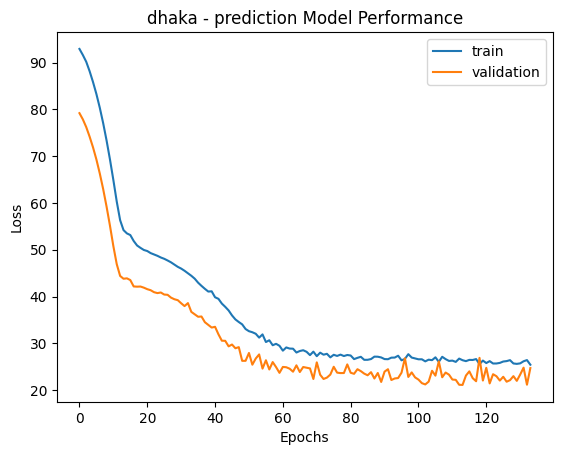

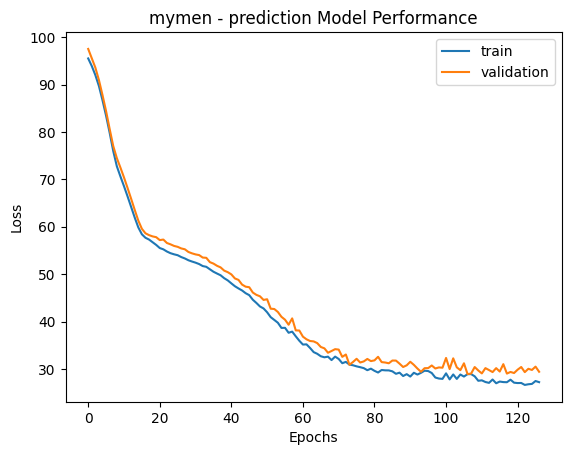

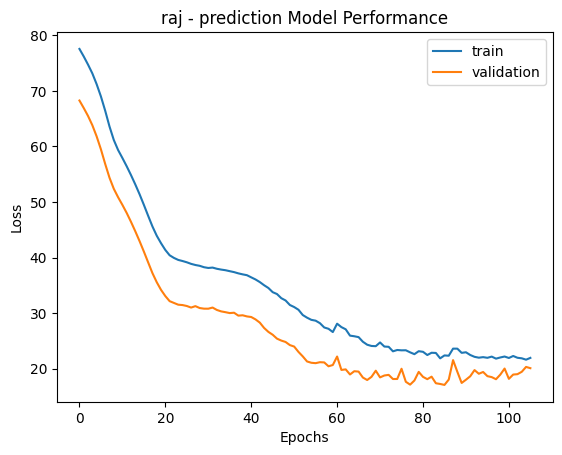

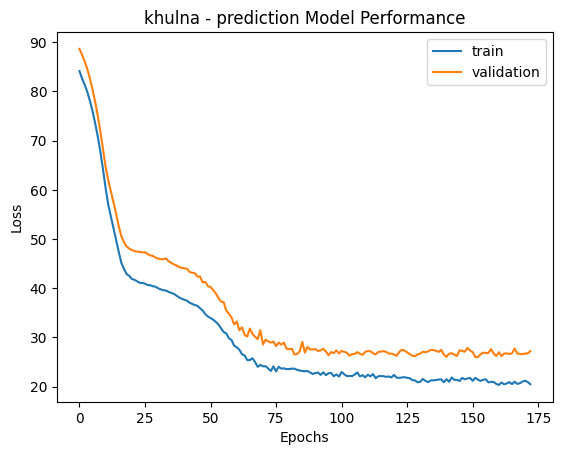

In [ ]:
# Train GRU model
dhaka_model = fit_gru('dhaka - prediction', x_train_dhaka, y_train_dhaka,
                      x_validation_dhaka, y_validation_dhaka)
mymen_model = fit_gru('mymen - prediction', x_train_mymen, y_train_mymen,
                      x_validation_mymen, y_validation_mymen)
raj_model = fit_gru('raj - prediction', x_train_raj, y_train_raj,
                    x_validation_raj, y_validation_raj)
khulna_model = fit_gru('khulna - prediction', x_train_khulna, y_train_khulna,
                       x_validation_khulna, y_validation_khulna)


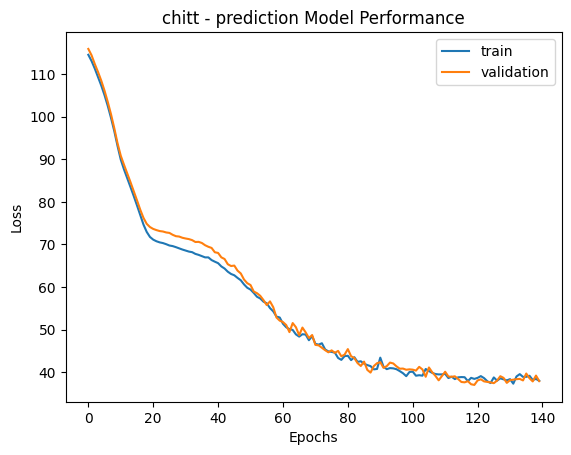

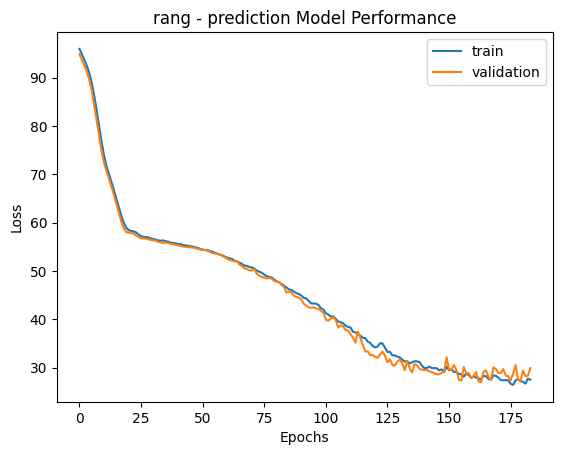

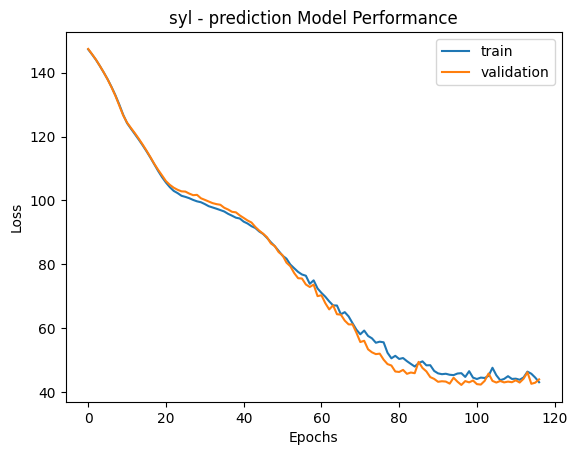

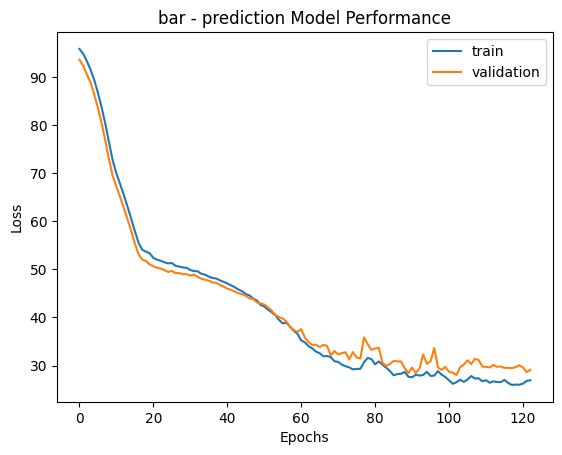

In [ ]:
# Train GRU model
chitt_model = fit_gru('chitt - prediction', x_train_chitt, y_train_chitt,
                      x_validation_chitt, y_validation_chitt)
rang_model = fit_gru('rang - prediction', x_train_rang, y_train_rang,
                     x_validation_rang, y_validation_rang)
syl_model = fit_gru('syl - prediction', x_train_syl, y_train_syl,
                    x_validation_syl, y_validation_syl)
bar_model = fit_gru('bar - prediction', x_train_bar, y_train_bar,
                    x_validation_bar, y_validation_bar)



In [ ]:
# Make predictions
y_pred_train_dhaka = dhaka_model.predict(x_train_dhaka)
y_pred_validation_dhaka = dhaka_model.predict(x_validation_dhaka)
y_pred_test_dhaka = dhaka_model.predict(x_test_dhaka)

3/3 [==============================] - 0s 5ms/step


In [ ]:
y_pred_train_mymen = mymen_model.predict(x_train_mymen)
y_pred_validation_mymen = mymen_model.predict(x_validation_mymen)
y_pred_test_mymen = mymen_model.predict(x_test_mymen)


4/4 [==============================] - 0s 4ms/step


In [ ]:
y_pred_train_raj = raj_model.predict(x_train_raj)
y_pred_validation_raj = raj_model.predict(x_validation_raj)
y_pred_test_raj = raj_model.predict(x_test_raj)


4/4 [==============================] - 0s 6ms/step


In [ ]:
y_pred_train_khulna = khulna_model.predict(x_train_khulna)
y_pred_validation_khulna = khulna_model.predict(x_validation_khulna)
y_pred_test_khulna = khulna_model.predict(x_test_khulna)


4/4 [==============================] - 0s 7ms/step


In [ ]:
y_pred_train_chitt = chitt_model.predict(x_train_chitt)
y_pred_validation_chitt = chitt_model.predict(x_validation_chitt)
y_pred_test_chitt = chitt_model.predict(x_test_chitt)


4/4 [==============================] - 0s 4ms/step


In [ ]:
y_pred_train_rang = rang_model.predict(x_train_rang)
y_pred_validation_rang = rang_model.predict(x_validation_rang)
y_pred_test_rang = rang_model.predict(x_test_rang)


4/4 [==============================] - 0s 4ms/step


In [ ]:
y_pred_train_syl = syl_model.predict(x_train_syl)
y_pred_validation_syl = syl_model.predict(x_validation_syl)
y_pred_test_syl = syl_model.predict(x_test_syl)


4/4 [==============================] - 0s 4ms/step


In [ ]:
y_pred_train_bar = bar_model.predict(x_train_bar)
y_pred_validation_bar = bar_model.predict(x_validation_bar)
y_pred_test_bar = bar_model.predict(x_test_bar)


4/4 [==============================] - 0s 5ms/step


In [ ]:
y_test_dhaka

array([[ 33.28, 171.  ,  77.74],
       [ 32.87, 138.  ,  82.13],
       [ 33.07,  76.  ,  74.77],
       [ 29.6 ,  25.  ,  73.  ],
       [ 27.76,   0.  ,  72.29],
       [ 26.37,   0.  ,  62.84],
       [ 29.57,   2.  ,  57.21],
       [ 30.48, 100.  ,  67.16],
       [ 32.79, 228.  ,  72.97],
       [ 34.5 , 188.  ,  73.23],
       [ 33.04, 414.  ,  80.2 ],
       [ 31.98, 584.  ,  83.84],
       [ 32.59, 544.  ,  83.06],
       [ 33.08, 381.  ,  82.2 ],
       [ 31.99, 412.  ,  79.87],
       [ 30.19,   6.  ,  67.73],
       [ 26.76,  33.  ,  76.61],
       [ 23.6 ,   0.  ,  68.97],
       [ 29.22,  20.  ,  61.54],
       [ 33.32,   3.  ,  59.77],
       [ 33.03, 309.  ,  69.67],
       [ 32.33, 392.  ,  79.16],
       [ 33.54, 366.  ,  81.53],
       [ 32.79, 354.  ,  81.71],
       [ 33.8 , 141.  ,  78.03],
       [ 34.13,  76.  ,  77.33],
       [ 31.99,  45.  ,  72.23],
       [ 30.29,  13.  ,  68.7 ],
       [ 26.14,  13.  ,  66.13],
       [ 27.17,   1.  ,  59.97],
       [ 2

In [ ]:
y_pred_test_dhaka

array([[ 32.03055  , 326.81943  ,  85.598526 ],
       [ 32.38875  , 231.0762   ,  83.16513  ],
       [ 29.54316  ,  63.392227 ,  75.773315 ],
       [ 29.974464 ,  63.332115 ,  76.32836  ],
       [ 28.402504 ,   9.678932 ,  69.59896  ],
       [ 28.402506 ,   9.678925 ,  69.59896  ],
       [ 28.402544 ,   9.679407 ,  69.599045 ],
       [ 28.42468  ,   9.914999 ,  69.65397  ],
       [ 30.946117 ,  98.09004  ,  73.47748  ],
       [ 32.010906 , 267.82706  ,  80.75227  ],
       [ 31.841087 , 324.99988  ,  85.087265 ],
       [ 32.004395 , 326.56827  ,  85.527954 ],
       [ 31.725382 , 322.0685   ,  84.55882  ],
       [ 32.304058 , 235.20299  ,  82.35837  ],
       [ 28.426683 ,  65.054016 ,  70.6075   ],
       [ 28.83506  ,  33.76902  ,  70.20669  ],
       [ 28.402506 ,   9.678959 ,  69.59896  ],
       [ 28.402504 ,   9.678921 ,  69.59896  ],
       [ 28.402504 ,   9.678921 ,  69.59896  ],
       [ 28.402504 ,   9.678919 ,  69.59895  ],
       [ 28.402504 ,   9.678921 ,  69.59

In [ ]:
# Evaluate the model (you may need to modify this based on your specific evaluation criteria)
train_mae = mean_absolute_error(y_train_dhaka, y_pred_train_dhaka)
validation_mae = mean_absolute_error(y_validation_dhaka, y_pred_validation_dhaka)
test_mae = mean_absolute_error(y_test_dhaka, y_pred_test_dhaka)

print(f"Train MAE: {train_mae:.2f}")
print(f"Validation MAE: {validation_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Train MAE: 25.84
Validation MAE: 21.11
Test MAE: 27.06


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Root Mean Squared Error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    mask = y_true > epsilon  # Filter out instances where true values are close to zero
    y_true, y_pred = np.array(y_true)[mask], np.array(y_pred)[mask]
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Function to calculate metrics for a city
def calculate_metrics(y_true, y_pred, city_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"{city_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("\n")



In [ ]:
# Calculate metrics for Dhaka
calculate_metrics(y_train_dhaka, y_pred_train_dhaka, "Dhaka (Train)")
calculate_metrics(y_validation_dhaka, y_pred_validation_dhaka, "Dhaka (Validation)")
calculate_metrics(y_test_dhaka, y_pred_test_dhaka, "Dhaka (Test)")

# Calculate metrics for MyMensingh
calculate_metrics(y_train_mymen, y_pred_train_mymen, "MyMensingh (Train)")
calculate_metrics(y_validation_mymen, y_pred_validation_mymen, "MyMensingh (Validation)")
calculate_metrics(y_test_mymen, y_pred_test_mymen, "MyMensingh (Test)")

# Calculate metrics for Rajshahi
calculate_metrics(y_train_raj, y_pred_train_raj, "Rajshahi (Train)")
calculate_metrics(y_validation_raj, y_pred_validation_raj, "Rajshahi (Validation)")
calculate_metrics(y_test_raj, y_pred_test_raj, "Rajshahi (Test)")

# Calculate metrics for Khulna
calculate_metrics(y_train_khulna, y_pred_train_khulna, "Khulna (Train)")
calculate_metrics(y_validation_khulna, y_pred_validation_khulna, "Khulna (Validation)")
calculate_metrics(y_test_khulna, y_pred_test_khulna, "Khulna (Test)")

# Calculate metrics for Chittagong
calculate_metrics(y_train_chitt, y_pred_train_chitt, "Chittagong (Train)")
calculate_metrics(y_validation_chitt, y_pred_validation_chitt, "Chittagong (Validation)")
calculate_metrics(y_test_chitt, y_pred_test_chitt, "Chittagong (Test)")

# Calculate metrics for Rangpur
calculate_metrics(y_train_rang, y_pred_train_rang, "Rangpur (Train)")
calculate_metrics(y_validation_rang, y_pred_validation_rang, "Rangpur (Validation)")
calculate_metrics(y_test_rang, y_pred_test_rang, "Rangpur (Test)")

# Calculate metrics for Sylhet
calculate_metrics(y_train_syl, y_pred_train_syl, "Sylhet (Train)")
calculate_metrics(y_validation_syl, y_pred_validation_syl, "Sylhet (Validation)")
calculate_metrics(y_test_syl, y_pred_test_syl, "Sylhet (Test)")

# Calculate metrics for Barisal
calculate_metrics(y_train_bar, y_pred_train_bar, "Barisal (Train)")
calculate_metrics(y_validation_bar, y_pred_validation_bar, "Barisal (Validation)")
calculate_metrics(y_test_bar, y_pred_test_bar, "Barisal (Test)")


Dhaka (Train) Metrics:
MAE: 25.84
MSE: 4229.40
RMSE: 65.03
MAPE: 30.80%


Dhaka (Validation) Metrics:
MAE: 21.11
MSE: 2104.49
RMSE: 45.87
MAPE: 37.75%


Dhaka (Test) Metrics:
MAE: 27.06
MSE: 3800.42
RMSE: 61.65
MAPE: 35.42%


MyMensingh (Train) Metrics:
MAE: 27.01
MSE: 5197.75
RMSE: 72.10
MAPE: 33.37%


MyMensingh (Validation) Metrics:
MAE: 28.93
MSE: 5580.32
RMSE: 74.70
MAPE: 32.14%


MyMensingh (Test) Metrics:
MAE: 23.89
MSE: 3480.80
RMSE: 59.00
MAPE: 41.27%


Rajshahi (Train) Metrics:
MAE: 22.23
MSE: 3255.25
RMSE: 57.05
MAPE: 38.65%


Rajshahi (Validation) Metrics:
MAE: 17.07
MSE: 1505.57
RMSE: 38.80
MAPE: 38.23%


Rajshahi (Test) Metrics:
MAE: 19.04
MSE: 1958.10
RMSE: 44.25
MAPE: 40.90%


Khulna (Train) Metrics:
MAE: 20.56
MSE: 2856.32
RMSE: 53.44
MAPE: 30.02%


Khulna (Validation) Metrics:
MAE: 25.99
MSE: 4749.46
RMSE: 68.92
MAPE: 39.62%


Khulna (Test) Metrics:
MAE: 25.64
MSE: 4528.19
RMSE: 67.29
MAPE: 41.79%


Chittagong (Train) Metrics:
MAE: 37.89
MSE: 10547.36
RMSE: 102.70
MAP

In [ ]:
# Calculate metrics for Dhaka

calculate_metrics(y_test_dhaka, y_pred_test_dhaka, "Dhaka (Test)")

# Calculate metrics for MyMensingh

calculate_metrics(y_test_mymen, y_pred_test_mymen, "MyMensingh (Test)")

# Calculate metrics for Rajshahi

calculate_metrics(y_test_raj, y_pred_test_raj, "Rajshahi (Test)")

# Calculate metrics for Khulna

calculate_metrics(y_test_khulna, y_pred_test_khulna, "Khulna (Test)")

# Calculate metrics for Chittagong

calculate_metrics(y_test_chitt, y_pred_test_chitt, "Chittagong (Test)")

# Calculate metrics for Rangpur

calculate_metrics(y_test_rang, y_pred_test_rang, "Rangpur (Test)")

# Calculate metrics for Sylhet

calculate_metrics(y_test_syl, y_pred_test_syl, "Sylhet (Test)")

# Calculate metrics for Barisal

calculate_metrics(y_test_bar, y_pred_test_bar, "Barisal (Test)")

Dhaka (Test) Metrics:
MAE: 27.06
MSE: 3800.42
RMSE: 61.65
MAPE: 35.42%


MyMensingh (Test) Metrics:
MAE: 23.89
MSE: 3480.80
RMSE: 59.00
MAPE: 41.27%


Rajshahi (Test) Metrics:
MAE: 19.04
MSE: 1958.10
RMSE: 44.25
MAPE: 40.90%


Khulna (Test) Metrics:
MAE: 25.64
MSE: 4528.19
RMSE: 67.29
MAPE: 41.79%


Chittagong (Test) Metrics:
MAE: 39.76
MSE: 15204.04
RMSE: 123.30
MAPE: 29.32%


Rangpur (Test) Metrics:
MAE: 30.09
MSE: 6486.68
RMSE: 80.54
MAPE: 54.27%


Sylhet (Test) Metrics:
MAE: 47.41
MSE: 14006.13
RMSE: 118.35
MAPE: 26.32%


Barisal (Test) Metrics:
MAE: 26.87
MSE: 4550.64
RMSE: 67.46
MAPE: 103.20%




In [ ]:
cities = ['Dhaka', 'Mymen', 'Raj', 'Khulna', 'Chitt', 'Rang', 'Syl', 'Bar']

for city in cities:
    dates_city = eval(f'{city.lower()}_test.index')
    y_test_city = eval(f'y_test_{city.lower()}')
    y_pred_test_city = eval(f'y_pred_test_{city.lower()}')

    print(f"Length of dates ({city}):", len(dates_city))
    print(f"Length of y_test_{city.lower()}:", len(y_test_city))
    print(f"Length of y_pred_test_{city.lower()}:", len(y_pred_test_city))
    print("\n")


Length of dates (Dhaka): 84
Length of y_test_dhaka: 77
Length of y_pred_test_dhaka: 77


Length of dates (Mymen): 132
Length of y_test_mymen: 125
Length of y_pred_test_mymen: 125


Length of dates (Raj): 107
Length of y_test_raj: 100
Length of y_pred_test_raj: 100


Length of dates (Khulna): 132
Length of y_test_khulna: 125
Length of y_pred_test_khulna: 125


Length of dates (Chitt): 132
Length of y_test_chitt: 125
Length of y_pred_test_chitt: 125


Length of dates (Rang): 120
Length of y_test_rang: 113
Length of y_pred_test_rang: 113


Length of dates (Syl): 122
Length of y_test_syl: 115
Length of y_pred_test_syl: 115


Length of dates (Bar): 132
Length of y_test_bar: 125
Length of y_pred_test_bar: 125




Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2016-01-01            33.28           32.030548            171.0   
1  2016-02-01            32.87           32.388748            138.0   
2  2016-03-01            33.07           29.543159             76.0   
3  2016-04-01            29.60           29.974464             25.0   
4  2016-05-01            27.76           28.402504              0.0   
..        ...              ...                 ...              ...   
72 2022-01-01            34.21           31.664452            130.0   
73 2022-02-01            33.21           31.955145            282.0   
74 2022-03-01            32.72           30.744648            297.0   
75 2022-04-01            31.04           28.940670              0.0   
76 2022-05-01            27.41           28.404379              4.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0           326.819427            77.74           85.598

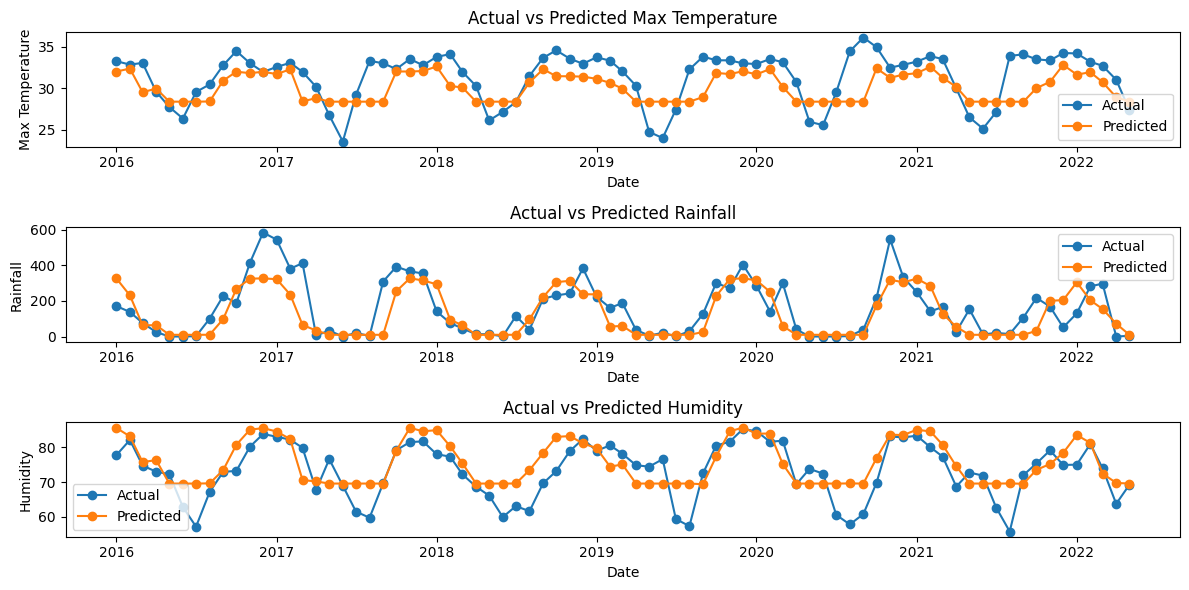

In [99]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = dhaka_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 77

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_dhaka[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_dhaka[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/softcom/pics/' + 'dhkGRU.png')
plt.show()


Actual and Predicted Values:
          Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0   2012-01-01            32.15           30.893032            238.0   
1   2012-02-01            32.01           30.355141            221.0   
2   2012-03-01            31.71           30.856007             45.0   
3   2012-04-01            28.37           27.494450             19.0   
4   2012-05-01            22.89           27.517536              0.0   
..         ...              ...                 ...              ...   
120 2022-01-01            33.36           31.277113            238.0   
121 2022-02-01            32.38           31.128071            343.0   
122 2022-03-01            31.98           30.867332            240.0   
123 2022-04-01            30.43           27.575294              0.0   
124 2022-05-01            26.41           27.494389              0.0   

     Predicted Rainfall  Actual Humidity  Predicted Humidity  
0            305.830566            85.10   

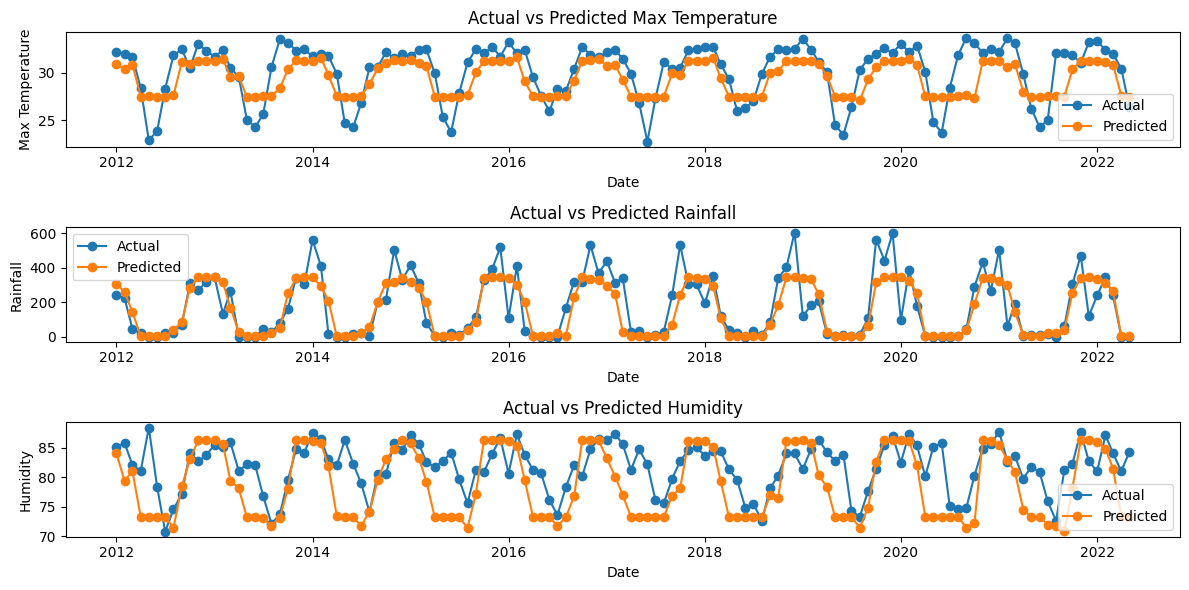

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = mymen_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 125

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_mymen[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_mymen[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2014-02-01            34.08           31.900963            153.0   
1  2014-03-01            32.51           32.300980              5.0   
2  2014-04-01            30.15           29.033195              0.0   
3  2014-05-01            24.57           28.333176              0.0   
4  2014-06-01            23.72           28.333176             14.0   
..        ...              ...                 ...              ...   
95 2022-01-01            34.71           32.974461            263.0   
96 2022-02-01            34.07           32.974926            329.0   
97 2022-03-01            33.06           31.415308             57.0   
98 2022-04-01            30.33           29.097223              0.0   
99 2022-05-01            26.78           28.333176              1.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0           233.196075            84.37           83.429

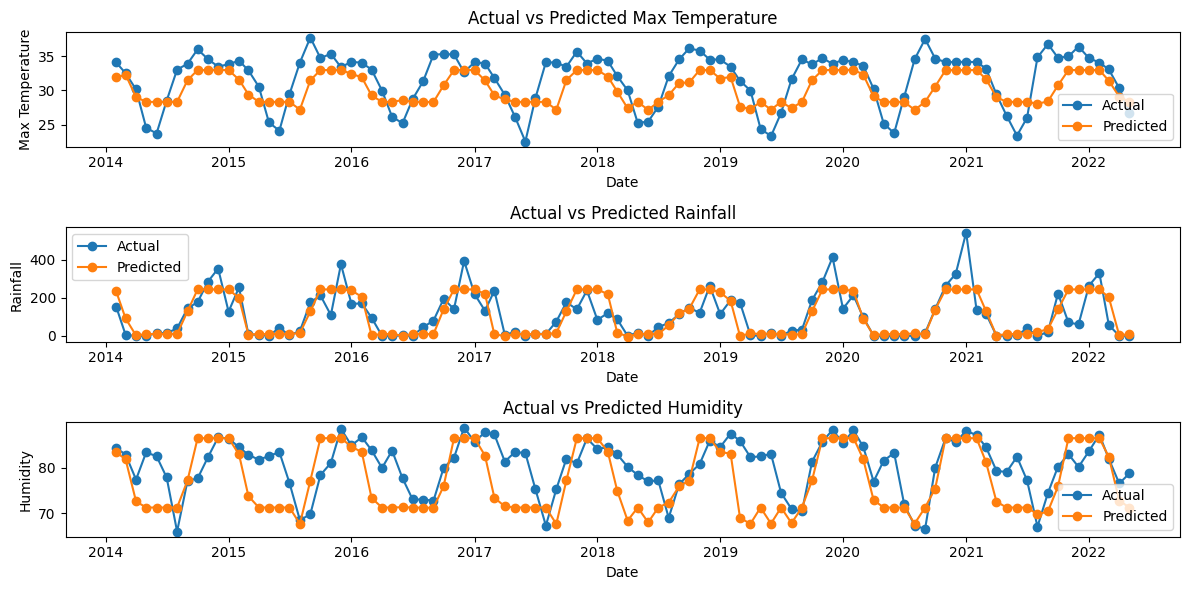

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = raj_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 100

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_raj[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_raj[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
          Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0   2012-01-01            32.82           32.265163            254.0   
1   2012-02-01            32.79           30.778934            374.0   
2   2012-03-01            32.33           32.423470             89.0   
3   2012-04-01            29.38           32.888828             80.0   
4   2012-05-01            25.06           28.398632              2.0   
..         ...              ...                 ...              ...   
120 2022-01-01            33.42           32.388729            184.0   
121 2022-02-01            33.33           32.593700            350.0   
122 2022-03-01            32.58           32.014000            292.0   
123 2022-04-01            30.66           30.389097              0.0   
124 2022-05-01            27.48           28.119267              0.0   

     Predicted Rainfall  Actual Humidity  Predicted Humidity  
0            292.732635            90.87   

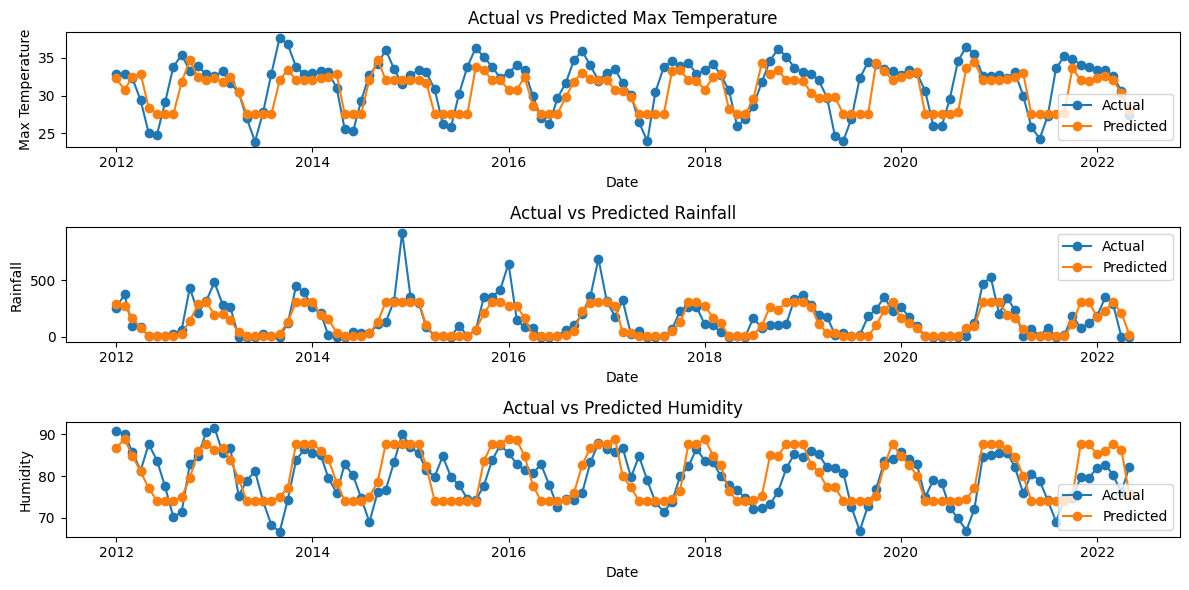

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = khulna_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 125

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_khulna[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_khulna[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
          Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0   2012-01-01            31.11           31.368834            299.0   
1   2012-02-01            31.24           31.353714            170.0   
2   2012-03-01            31.15           28.716017            636.0   
3   2012-04-01            28.76           29.863495              3.0   
4   2012-05-01            24.73           27.913061              0.0   
..         ...              ...                 ...              ...   
120 2022-01-01            33.27           31.329288            116.0   
121 2022-02-01            32.55           31.159573            386.0   
122 2022-03-01            32.82           31.365608            154.0   
123 2022-04-01            31.47           31.467373              0.0   
124 2022-05-01            28.50           27.927336             20.0   

     Predicted Rainfall  Actual Humidity  Predicted Humidity  
0            436.866760            86.65   

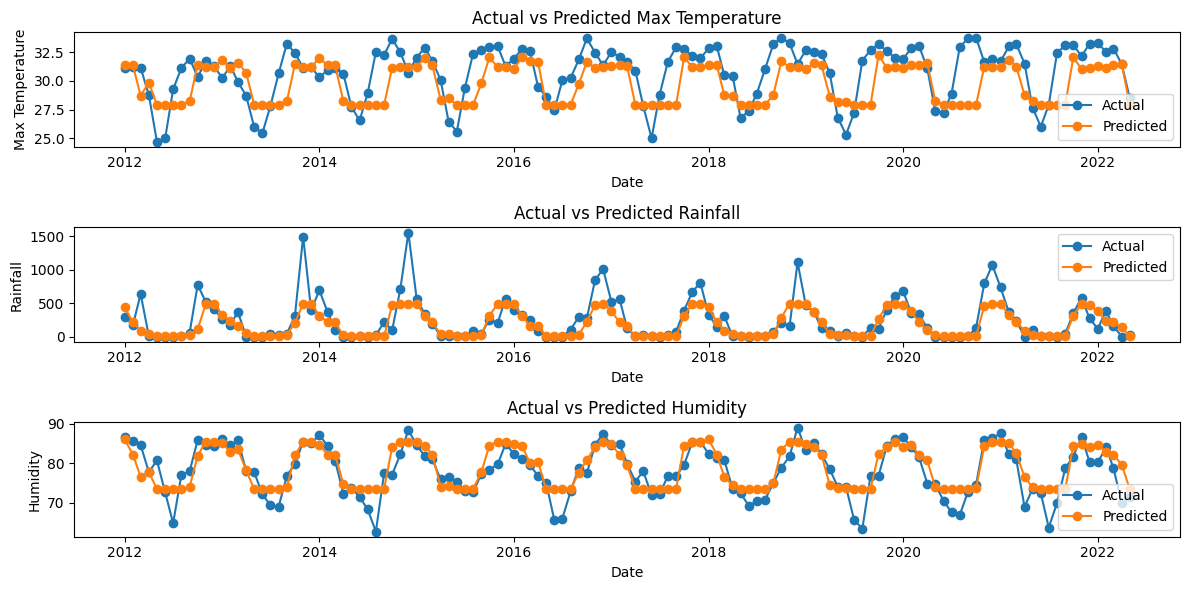

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = chitt_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 125

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_chitt[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_chitt[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2013-01-01            32.18           31.961040            268.0   
1  2013-02-01            32.94           31.106953            229.0   
2  2013-03-01            30.05           30.666105            280.0   
3  2013-04-01            28.63           27.935091              0.0   
4  2013-05-01            24.36           26.781929              0.0   
..        ...              ...                 ...              ...   
95 2020-12-01            33.23           31.961040            194.0   
96 2021-01-01            33.01           31.961040            424.0   
97 2021-02-01            33.73           31.961040            193.0   
98 2021-03-01            32.38           30.862020            384.0   
99 2021-04-01            29.56           29.672775              0.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0           346.448639            84.13           85.586

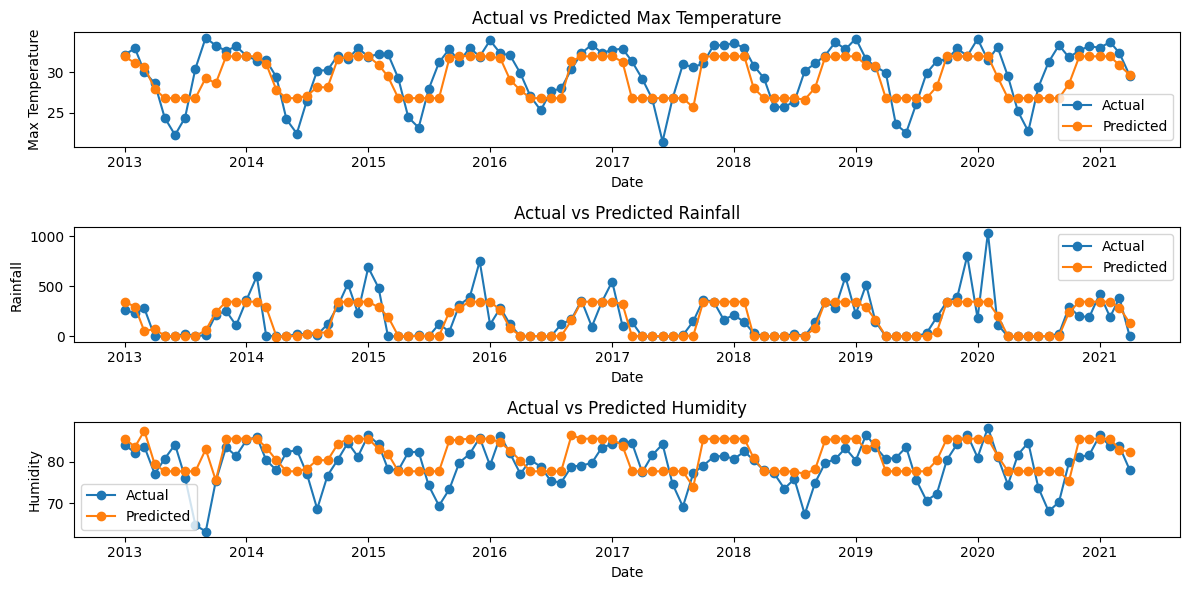

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = rang_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 100

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_rang[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_rang[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2012-11-01            34.06           31.394794            729.0   
1  2012-12-01            33.21           31.397194            567.0   
2  2013-01-01            32.58           31.397194            520.0   
3  2013-02-01            32.83           32.495144            347.0   
4  2013-03-01            31.47           31.099550            451.0   
..        ...              ...                 ...              ...   
95 2020-10-01            33.07           30.767067            290.0   
96 2020-11-01            32.15           31.397194            664.0   
97 2020-12-01            32.98           31.397194            703.0   
98 2021-01-01            31.84           31.397194            928.0   
99 2021-02-01            34.56           31.394745            200.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0           564.972717            81.17           87.218

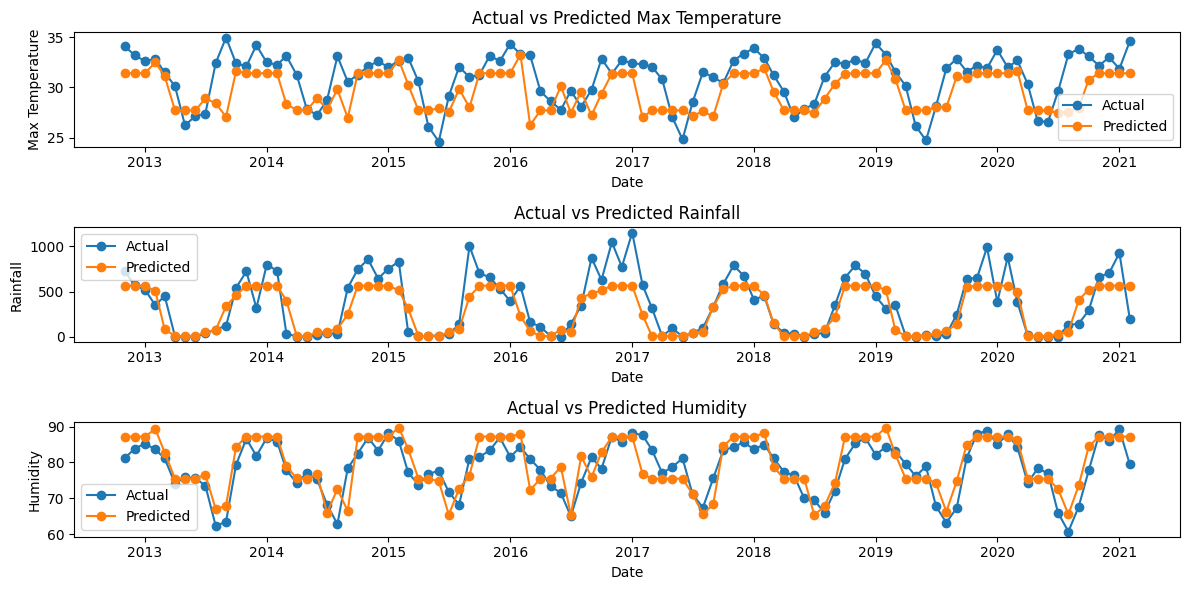

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = syl_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 100

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_syl[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_syl[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2012-01-01            32.09           31.461769            270.0   
1  2012-02-01            31.82           30.860001            381.0   
2  2012-03-01            32.05           30.856970             70.0   
3  2012-04-01            29.16           28.346600             44.0   
4  2012-05-01            25.20           27.769302              0.0   
..        ...              ...                 ...              ...   
95 2019-12-01            32.64           31.457918            310.0   
96 2020-01-01            32.18           30.730394            453.0   
97 2020-02-01            33.11           30.962408            408.0   
98 2020-03-01            32.84           31.619968            278.0   
99 2020-04-01            30.59           30.054157              5.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0           334.745209            87.45           88.150

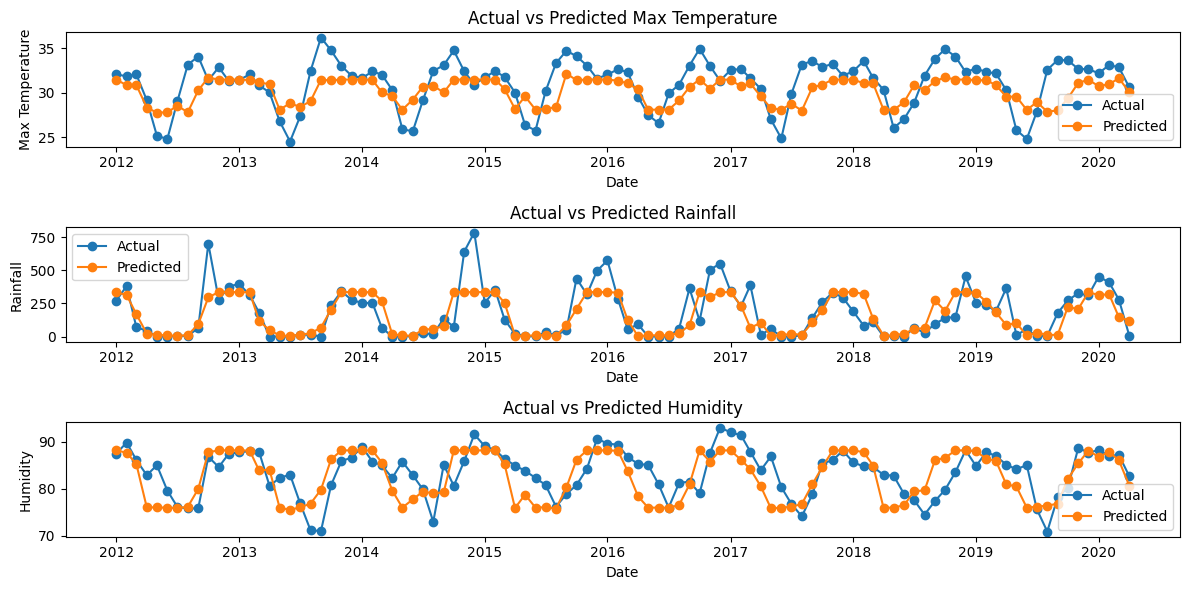

In [ ]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = bar_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 100

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_bar[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_bar[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics_new(y_true, y_pred, city_name):
    mse_max_temp = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mae_max_temp = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_max_temp = np.sqrt(mse_max_temp)
    mape_max_temp = mean_absolute_percentage_error(y_true[:, 0], y_pred[:, 0])

    mse_rainfall = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    mae_rainfall = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_rainfall = np.sqrt(mse_rainfall)
    mape_rainfall = mean_absolute_percentage_error(y_true[:, 1], y_pred[:, 1])

    mse_humidity = mean_squared_error(y_true[:, 2], y_pred[:, 2])
    mae_humidity = mean_absolute_error(y_true[:, 2], y_pred[:, 2])
    rmse_humidity = np.sqrt(mse_humidity)
    mape_humidity = mean_absolute_percentage_error(y_true[:, 2], y_pred[:, 2])

    print(f"Metrics for {city_name}:")
    print(f"Max Temp - MSE: {mse_max_temp}, MAE: {mae_max_temp}, RMSE: {rmse_max_temp}, MAPE: {mape_max_temp}%")
    print(f"Rainfall - MSE: {mse_rainfall}, MAE: {mae_rainfall}, RMSE: {rmse_rainfall}, MAPE: {mape_rainfall}%")
    print(f"Humidity - MSE: {mse_humidity}, MAE: {mae_humidity}, RMSE: {rmse_humidity}, MAPE: {mape_humidity}%")
    print("\n\n")


In [ ]:
# Calculate metrics for Dhaka

calculate_metrics_new(y_test_dhaka, y_pred_test_dhaka, "Dhaka (Test)")

# Calculate metrics for MyMensingh

calculate_metrics_new(y_test_mymen, y_pred_test_mymen, "MyMensingh (Test)")

# Calculate metrics for Rajshahi

calculate_metrics_new(y_test_raj, y_pred_test_raj, "Rajshahi (Test)")

# Calculate metrics for Khulna

calculate_metrics_new(y_test_khulna, y_pred_test_khulna, "Khulna (Test)")

# Calculate metrics for Chittagong

calculate_metrics_new(y_test_chitt, y_pred_test_chitt, "Chittagong (Test)")

# Calculate metrics for Rangpur

calculate_metrics_new(y_test_rang, y_pred_test_rang, "Rangpur (Test)")

# Calculate metrics for Sylhet

calculate_metrics_new(y_test_syl, y_pred_test_syl, "Sylhet (Test)")

# Calculate metrics for Barisal

calculate_metrics_new(y_test_bar, y_pred_test_bar, "Barisal (Test)")


Metrics for Dhaka (Test):
Max Temp - MSE: 7.002712381309734, MAE: 2.173041095485935, RMSE: 2.6462638533052094, MAPE: 6.959582952019544%
Rainfall - MSE: 11360.806438386151, MAE: 74.4236818784243, RMSE: 106.58708382532168, MAPE: 98.31612224946457%
Humidity - MSE: 33.437003432798555, MAE: 4.569457484654018, RMSE: 5.782473816006308, MAPE: 6.703063579892243%



Metrics for MyMensingh (Test):
Max Temp - MSE: 4.910886870406913, MAE: 1.807577633666992, RMSE: 2.216052091086063, MAPE: 6.15633265488444%
Rainfall - MSE: 10408.300342658971, MAE: 65.6572434501648, RMSE: 102.02107793323383, MAPE: 125.31970170143076%
Humidity - MSE: 29.17829103323999, MAE: 4.204176096191406, RMSE: 5.401693348686131, MAPE: 5.117722477834601%



Metrics for Rajshahi (Test):
Max Temp - MSE: 11.090674695248135, MAE: 2.726612985992432, RMSE: 3.3302664600971696, MAPE: 8.716729646600951%
Rainfall - MSE: 5818.975358757011, MAE: 49.237710528075695, RMSE: 76.28220866464873, MAPE: 120.26808517489695%
Humidity - MSE: 44.247370520